<a href="https://colab.research.google.com/github/Pembo2008/Kaggle/blob/main/Sales_Prediction_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import seaborn as sns

### import Data

In [ ]:
item_categories = pd.read_csv('/content/drive/MyDrive/kaggle/item_categories.csv')
items = pd.read_csv('/content/drive/MyDrive/kaggle/items.csv')
sales_train = pd.read_csv('/content/drive/MyDrive/kaggle/sales_train.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/kaggle/sample_submission.csv')
shops = pd.read_csv('/content/drive/MyDrive/kaggle/shops.csv')
test = pd.read_csv('/content/drive/MyDrive/kaggle/test.csv')

In [ ]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
sales_train.item_cnt_day.value_counts()

1.0       2629372
2.0        194201
3.0         47350
4.0         19685
5.0         10474
           ...   
251.0           1
501.0           1
112.0           1
164.0           1
2169.0          1
Name: item_cnt_day, Length: 198, dtype: int64

In [ ]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [ ]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


### Exploratory analisys

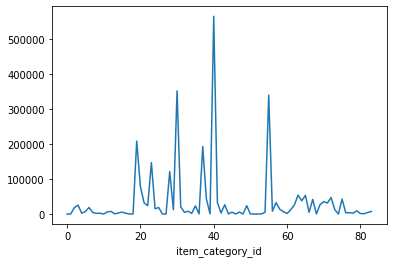

In [ ]:
temp = sales_train.merge(items,how='inner',on="item_id")
temp.groupby("item_category_id")['item_id'].count().plot()

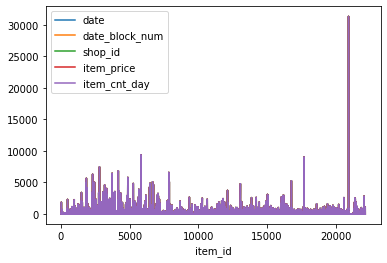

In [ ]:
sales_train.groupby("item_id").count().plot()

In [ ]:
sales_train.groupby("item_id").count().date.max()

31340

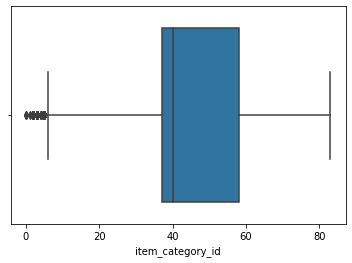

In [ ]:
import seaborn as sns
sns.boxplot(x="item_category_id",data=items)

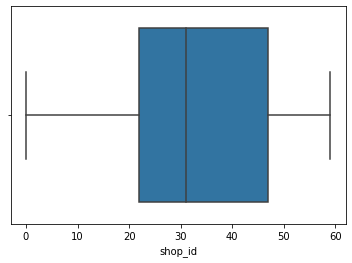

In [ ]:
sns.boxplot(x="shop_id",data=sales_train)

In [ ]:
shops[shops["shop_id"]==20]

,shop_name,shop_id
20,"Москва ""Распродажа""",20


In [ ]:
shops[shops["shop_id"]==31]

,shop_name,shop_id
31,"Москва ТЦ ""Семеновский""",31


In [ ]:
shops[shops["shop_id"]==32]

,shop_name,shop_id
32,"Москва ТЦ ""Серебряный Дом""",32


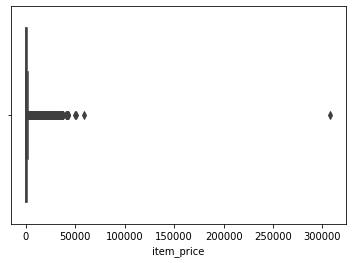

In [ ]:
sns.boxplot(x="item_price",data=sales_train)

In [ ]:
sales_train[sales_train["item_price"]>300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [ ]:
items[items.item_id==6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [ ]:
temp = sales_train.merge(items,how='inner',on="item_id")
len(temp.groupby("item_category_id").sum())

84

### Разделение данных

In [ ]:
matrix = sales_train.pivot_table(index = ['shop_id','item_id'], columns = ['date_block_num'],values = ['item_cnt_day'],fill_value = 0,aggfunc='sum')
matrix.reset_index(inplace = True)
X_train = matrix.drop(columns=['shop_id','item_id'],level = 0)
X_train.head(10)

item_cnt_day                              ...                 \
date_block_num           0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
0                         0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
1                         0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
2                         6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
3                         3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
4                         1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
5                         0   1  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
6                         0   1  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
7                         0   1  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
8                         1   0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
9                         0   2  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   

                               
date_block_num 29 30 31 32 33  
0               0  0  0  0  0  
1               0  0  0  0  0  
2               0  0  0  0  0  
3               0  0  0  0  0  
4               0  0  0  0  0  
5               0  0  0  0  0  
6               0  0  0  0  0  
7               0  0  0  0  0  
8               0  0  0  0  0  
9               0  0  0  0  0  

[10 rows x 34 columns]

In [ ]:
X_train.fillna(0,inplace = True)

In [ ]:
y_train = X_train.values[:,-1:]
X_train = np.expand_dims(X_train.values[:,:-1],axis=2)

In [ ]:
print(X_train.shape,y_train.shape)

(424124, 33, 1) (424124, 1)


In [ ]:
test_matrix = matrix.merge(test, how="right",on = ["item_id","shop_id"])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


In [ ]:
test_matrix.head()

,item_id,shop_id,"(shop_id, )","(item_id, )","(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)",...,"(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)",ID
0,5037,5,5.0,5037.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,0
1,5320,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,5233,5,5.0,5233.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,2
3,5232,5,5.0,5232.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
4,5268,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [ ]:
X_test = test_matrix.drop(test_matrix.columns[:5],axis = 1).drop('ID',axis = 1)

In [ ]:
X_test.fillna(0,inplace=True)

In [ ]:
X_test.shape

(214200, 33)

### Creating model

In [ ]:
from keras import layers
model = keras.Sequential([
     layers.Dense(512,input_shape = [33],activation='relu'),
     layers.BatchNormalization(),
     layers.Dropout(0.3),
     layers.Dense(256,activation='relu'),
     layers.BatchNormalization(),
     layers.Dropout(0.3),
     layers.Dense(128,activation='relu'),
     layers.BatchNormalization(),
     layers.Dropout(0.3),
     layers.Dense(1)
])

In [ ]:
model.compile(
    optimizer = "adam",
    loss = "mse",
    metrics = "mean_squared_error"
)

In [ ]:
X_train = X_train.squeeze(2)

In [ ]:
X_train.shape

(424124, 33)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience = 5,
    min_delta = 0.001,
    restore_best_weights = True
)
history = model.fit(
    X_train,
    y_train,
    epochs = 10,
    batch_size = 128,
    verbose=1, 
    shuffle=True,
    validation_split= 0.3
)

Epoch 1/10
 235/2320 [==>...........................] - ETA: 22s - loss: 2.2625 - mean_squared_error: 2.2625

KeyboardInterrupt: ignored

In [ ]:
history = pd.DataFrame(history.history)
history

AttributeError: ignored

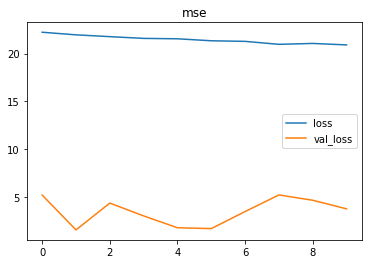

In [ ]:
history.loc[:,["loss","val_loss"]].plot(title = "mse")

### Regression

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [ ]:
from sklearn import metrics
def calc_metrics(true, pred):
    mse = metrics.mean_squared_error(true, pred)

    rmse = np.sqrt(mse)

    mae = metrics.mean_absolute_error(true, pred)

    medae = metrics.median_absolute_error(true, pred)

    R2 = metrics.r2_score(true, pred)

    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}".format(mse, rmse, R2, mae, medae))

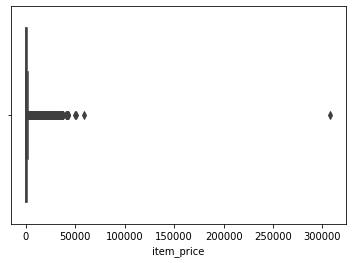

In [ ]:
sns.boxplot(x = "item_price",data=sales_train)

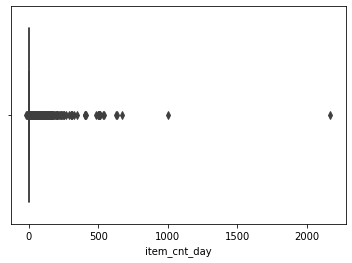

In [ ]:
sns.boxplot(x = "item_cnt_day",data=sales_train)

In [ ]:
out1 = sales_train[sales_train["item_price"]>300000].index[0]
out2 = sales_train[sales_train["item_cnt_day"]>2000].index[0]

In [ ]:
sales_train.drop([out1,out2],axis = 0,inplace=True)
sales_train.reset_index(inplace=True, drop=True)

In [ ]:
df_train_max_month = sales_train.date_block_num.max()
test['date_block_num'] = df_train_max_month + 1
df_data = pd.concat([sales_train,test]).reset_index(drop=True)
monthly_sales = df_data.groupby(by = ['date_block_num','shop_id','item_id'], as_index=False).agg({'item_cnt_day':'sum'})
monthly_sales = monthly_sales.rename(columns={'item_cnt_day':'item_cnt_month'})

In [ ]:
split_ratio = 0.8
train_valid_split = np.floor(df_train_max_month * split_ratio)
train_data = monthly_sales[monthly_sales['date_block_num'] <= train_valid_split]
valid_data = monthly_sales[(monthly_sales['date_block_num'] > train_valid_split) & (monthly_sales['date_block_num'] < df_train_max_month + 1)]
test_data = monthly_sales[monthly_sales['date_block_num'] == df_train_max_month+1]

In [ ]:
X_train = train_data.drop('item_cnt_month',axis=1)
y_train = train_data['item_cnt_month']

X_valid = valid_data.drop('item_cnt_month',axis=1)
y_valid = valid_data['item_cnt_month']

X_test = test_data.drop('item_cnt_month',axis=1)
y_test = test_data['item_cnt_month']

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [ ]:
valid_pred = lr.predict(X_valid)
calc_metrics(y_valid,valid_pred)

MSE:   103.36492416171471
RMSE:  10.16685419201607
R2:    -0.0008966283964277899
MAE:   1.8204899826407261
MedAE: 1.3969839467780762


In [ ]:
valid_pred = lr.predict(X_test)
calc_metrics(y_test,valid_pred)

MSE:   6.106948453042742
RMSE:  2.471224079892947
R2:    0.0
MAE:   2.4688001929944225
MedAE: 2.464389105851925


In [ ]:
ridge = Ridge(alpha = 9.9)
ridge.fit(X_train,y_train)
ridge_pred = ridge.predict(X_valid)
calc_metrics(y_valid,ridge_pred)

MSE:   103.36492415107962
RMSE:  10.16685419149304
R2:    -0.0008966282934466108
MAE:   1.8204899699566273
MedAE: 1.3969839258605794


In [ ]:
valid_pred = ridge.predict(X_test)
calc_metrics(y_test,valid_pred)

MSE:   6.106948342081907
RMSE:  2.4712240574423654
R2:    0.0
MAE:   2.468800170520083
MedAE: 2.4643890834108237


In [ ]:
RidgeModel = linear_model.RidgeCV(alphas = np.arange(0.1,10,0.1))
RidgeModel.fit(X_train, y_train)

RidgeCV(alphas=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]))

In [ ]:
RidgeModel.alpha_

9.9

In [ ]:
lasso = Lasso(alpha = 1.7)
lasso.fit(X_train,y_train)
lasso_pred = lasso.predict(X_valid)
calc_metrics(y_valid,lasso_pred)

MSE:   103.29781378611672
RMSE:  10.163553206734184
R2:    -0.00024678949593792687
MAE:   1.7127096325942361
MedAE: 1.239562640559491


In [ ]:
valid_pred = lasso.predict(X_test)
calc_metrics(y_test,valid_pred)

MSE:   5.202602865152442
RMSE:  2.2809214947368184
R2:    0.0
MAE:   2.278341430113977
MedAE: 2.275156676751674


In [ ]:
LassoModel = linear_model.LassoCV(alphas = np.arange(0.1,10,0.1))
LassoModel.fit(X_train, y_train)

LassoCV(alphas=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]))

In [ ]:
LassoModel.alpha_

1.7000000000000002

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
r2_max, neighbors_max = 0, 0
for i in range(1,16):
  knn = KNeighborsRegressor(i,weights="uniform")
  knn.fit(X_train,y_train)
  y_pred = knn.predict(X_test)
  r2 = metrics.r2_score(y_test,y_pred)
  if r2 > r2_max:
        r2_max, neighbors_max = r2, i

In [ ]:
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MSE: 14.633197323373796
MAE: 1.8883681917211326
R2: 0.0
MAPE: 8504454284573590.0


Polynomial

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2,include_bias=True)
poly.fit(X_train)
poly_train = poly.transform(X_train)
poly_test = poly.transform(X_test)

In [ ]:
regressionModel = linear_model.LinearRegression(normalize=True)
regressionModel.fit(poly_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


LinearRegression(normalize=True)

In [ ]:
print('Train:')
calc_metrics(y_train, regressionModel.predict(poly_train))

print('\nTest:')
calc_metrics(y_test, regressionModel.predict(poly_test))

Train:
MSE:   66.39953092064091
RMSE:  8.148590732184363
R2:    0.001989895205197878
MAE:   1.7747635719634327
MedAE: 1.126209169439385

Test:
MSE:   4.33160109994201
RMSE:  2.0812498888749547
R2:    0.0
MAE:   2.0522204051664805
MedAE: 1.9741884278584885


In [ ]:
submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':valid_pred})